# Libraries

In [40]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Assignment III - Epipolar Geometry & 8-Point Algorithm

## Epipolar Geometry

Epipolar geometry is a branch of computer vision and geometry that deals with the relationship between two views of the same 3D scene. Specifically, it studies the relationship between corresponding points in two images taken by two cameras that are observing the same scene from different viewpoints.

The fundamental concept in epipolar geometry is the epipolar plane, which is the plane that contains the baseline between the two cameras and a 3D point in the scene. The intersection of this plane with each of the image planes results in a line called an epipolar line.

The epipolar lines have important properties that can be exploited to simplify the task of finding correspondences between the two images. Specifically, given a point in one image, its corresponding point in the other image must lie on the epipolar line associated with that point. This means that instead of searching the entire image for a correspondence, we can restrict our search to the epipolar line, which significantly reduces the search space.

Epipolar geometry is a fundamental concept in stereo vision, which is the process of extracting 3D information from two or more 2D images. It is also important in other computer vision tasks such as structure from motion, visual odometry, and robot navigation.

### Fundamental Matrix

The fundamental matrix F is a mathematical representation of the epipolar geometry between two calibrated cameras observing the same scene. It is a 3x3 matrix that relates corresponding points in two images, and it encodes the geometric relationship between the two views.

The fundamental matrix is defined as follows: 

- Given a pair of corresponding points, $x$ in the first image and $x'$ in the second image, the fundamental matrix $F$ satisfies the equation $x'Fx = 0$. This equation is known as the **epipolar constraint**, and it expresses the fact that the corresponding point $x'$ must lie on the epipolar line associated with $x$, and vice versa.

The fundamental matrix can be computed using a set of corresponding points in the two images. This process is known as the **8-point algorithm**, which involves solving a set of linear equations using the correspondences. However, in practice, more robust methods that can handle outliers and noise in the correspondences are often used.

The fundamental matrix F can be used to compute the epipolar lines associated with a given point in one image, which can be used to search for the corresponding point in the other image. It can also be used to compute the relative camera pose between the two cameras, which is important for 3D reconstruction and other computer vision applications.

### 8 point Algorithm

The 8-point algorithm is a method for computing the fundamental matrix F from a set of at least 8 corresponding points in two images. It is a simple and widely used method, although it has some limitations, such as being sensitive to outliers and requiring that the correspondences are accurately identified.

Here are the general steps of the 8-point algorithm:

1. **Normalize the image points**: This step involves applying a normalization transformation to the image points to make them have zero mean and unit variance. This helps to improve the numerical stability of the subsequent computations.

2. **Formulate the linear system**: The goal is to find the elements of the fundamental matrix that satisfy the epipolar constraint for each of the corresponding point pairs. This leads to a set of linear equations of the form $Af = 0$, where $A$ is a matrix constructed from the image points, and $f$ is a vector containing the elements of F.

3. **Solve the linear system**: The linear system can be solved using methods such as **singular value decomposition** (SVD) or the **pseudo-inverse** (we will use SVD). The solution is a least-squares estimate of the fundamental matrix.

4. **Enforce the rank-2 constraint**: The fundamental matrix F must have rank 2 in order to be valid. This constraint can be enforced by computing the SVD of the estimated $F$, setting the smallest s**ingular value to zero**, and *reconstructing* $F$.

5. **Denormalize the fundamental matrix**: The normalization applied to the image points in step 1 needs to be reversed in order to obtain the fundamental matrix in the original image coordinate system.

The 8-point algorithm is a simple and effective way to compute the fundamental matrix, but it has some limitations. For example, it assumes that the image points are accurately identified and correspond to the same physical points in the scene. It is also sensitive to outliers and noise in the image correspondences. More advanced techniques, such as RANSAC, can be used to improve the robustness and accuracy of the fundamental matrix estimation, which we will also apply.

## Sources:
[**Prof. Dr. Cyrill Stachniss**](https://www.ipb.uni-bonn.de/people/cyrill-stachniss/)<br><br>

[**Photogrammetry** by Prof. Dr. Cyrill Stachniss](https://www.ipb.uni-bonn.de/photo12-2021/)<br><br>

[**Epipolar Geometry** by Prof. Dr. Cyrill Stachniss](https://www.ipb.uni-bonn.de/html/teaching/photo12-2021/2021-pho2-03-epipolar-geometry.pptx.pdf)  <br><br>

[**Direct Solutions for Computing Fundamental and Essential Matrix** by Prof. Dr. Cyrill Stachniss](https://www.ipb.uni-bonn.de/html/teaching/photo12-2021/2021-pho2-04-fe-direct.pptx.pdf)<br><br>

[**RANSAC** – Random Sample Consensus by Prof. Dr. Cyrill Stachniss](https://www.ipb.uni-bonn.de/html/teaching/photo12-2021/2021-pho2-06-ransac.pptx.pdf)<br><br>


# Part I - Normalized 8-Point Algorithm

In this section, we will start by estimating the Fundamental matrix F relating the two images provided to us. By following the steps of the 8 point algorithm which have been discussed in the previous section

1. ## Normalize the points

In [2]:
def normalize_points(points):

    """
    Normalize points so that the centroid is at the origin
    and the average distance from the origin is sqrt(2).

    Parameters:
        :points: The points to be normalized
        
    Returns: 
        Normalized points and normalizing Factor
    """
    # Normalize image points to have zero mean and unit variance
    mean = np.mean(points, axis=0)
    scale = np.sqrt(2) / np.std(points - mean)
    T = np.array([[scale, 0, -scale*mean[0]],
                  [0, scale, -scale*mean[1]],
                  [0, 0, 1]])
    return np.dot(T, np.concatenate([points.T, np.ones((1, points.shape[0]))])).T, T

2. ## Denomarlize the Fundamental Matrix

In [3]:
def denormalize_fundamental_matrix(F, T1, T2):

    """
    Denormalize the Fundamental matrix F given the normalization
    transformations T1 and T2.

    Parameters:
        :F: Fundamental Matrix
        :T1 and T2: Normalization transformations
        
    Returns: 
        Denomarlized F matrix (3x3)
    """

    # Denormalize the fundamental matrix
    return np.dot(T2.T, np.dot(F, T1))

3. ## Find the Fundamental Matrix

In [4]:
def fundamental_matrix(points1, points2):

    '''
    The fundamental_matrix function computes the fundamental matrix
    from a set of corresponding points in two images.

    Parameters:

    points1: numpy array of shape (n, 2) containing n points in the first image
    points2: numpy array of shape (n, 2) containing n points in the second image


    Returns:

    F: numpy array of shape (3, 3) representing the fundamental matrix
    '''
    # Normalize image points
    points1_norm, T1 = normalize_points(points1)
    points2_norm, T2 = normalize_points(points2)

    # Construct the A matrix
    A = np.zeros((points1.shape[0], 9))
    for i in range(points1.shape[0]):
        x1, y1 = points1_norm[i, :2]
        x2, y2 = points2_norm[i, :2]
        A[i, :] = [x1*x2, y1*x2, x2, x1*y2, y1*y2, y2, x1, y1, 1]

    # Solve the linear system using SVD
    U, S, V = np.linalg.svd(A)
    F = V[-1, :].reshape(3, 3)

    # Enforce the rank-2 constraint
    U, S, V = np.linalg.svd(F)
    S[-1] = 0
    F = np.dot(U, np.dot(np.diag(S), V))

    # Denormalize the fundamental matrix
    F = denormalize_fundamental_matrix(F, T1, T2)

    return F / F[2, 2]

## Fundamental Matrix using RANSAC

To implement a RANSAC algorithm and combine it with the Fundamental matrix estimation, we can follow these steps:

1. Define a threshold for the distance of points to the epipolar line to be considered as inliers.

2. Randomly select a minimum number of points (e.g. 8) to compute the Fundamental matrix.

3. Use these points to estimate the Fundamental matrix using the fundamental_matrix function defined above.

4. Compute the epipolar lines for each point in both images using the estimated Fundamental matrix.

5. For each point, compute the distance to its corresponding epipolar line in both images.
Count the number of inliers (points whose distances to the epipolar lines are below the threshold).

6. Repeat steps 2-6 for a predefined number of iterations (e.g. 1000).

7. Return the Fundamental matrix computed using the inliers from the iteration with the largest number of inliers.

In [5]:
def ransac_fundamental_matrix(points1, points2, error_threshold=0.01, confidence=0.999):
    """
    Estimate the fundamental matrix robust to outliers using RANSAC.

    Args:
        points1 (ndarray): Array of shape (n, 2) containing the coordinates of the points in the first image.
        points2 (ndarray): Array of shape (n, 2) containing the coordinates of the points in the second image.
        error_threshold (float): The inlier threshold distance in pixels.
        confidence (float): The desired confidence level.

    Returns:
        ndarray: Array of shape (3, 3) containing the estimated fundamental matrix.
    """
    num_points = points1.shape[0]
    best_F = None
    best_inliers = []
    max_iterations = np.inf
    k = 0

    while k < max_iterations:

        # Randomly select a minimum number of points
        idx = np.random.choice(range(num_points), size=8, replace=False)
        p1 = points1[idx]
        p2 = points2[idx]

        # Compute the Fundamental matrix using the selected points
        F = fundamental_matrix(p1, p2)

        # Compute the epipolar lines and distances for each point
        lines1 = np.dot(F, np.concatenate([points2, np.ones((num_points, 1))], axis=1).T)
        lines2 = np.dot(F.T, np.concatenate([points1, np.ones((num_points, 1))], axis=1).T)
        d1 = np.abs(np.sum(points1 * lines1[:2].T, axis=1) + lines1[2])
        d2 = np.abs(np.sum(points2 * lines2[:2].T, axis=1) + lines2[2])

        # Count the inliers
        inliers = (d1 < error_threshold) & (d2 < error_threshold)

        # Check if we have a new best set of inliers
        if np.sum(inliers) > np.sum(best_inliers):
            best_inliers = inliers
            best_F = F
            inlier_ratio = np.sum(best_inliers) / num_points
            max_iterations = np.log(1 - confidence) / np.log(1 - inlier_ratio**8)
            max_iterations = np.minimum(max_iterations, 1000)

        k += 1

    # Compute the Fundamental matrix using the inliers
    F = fundamental_matrix(points1[best_inliers], points2[best_inliers])

    return F

In [6]:
def fundamental_matrix_ransac_using_open_cv(points1, points2, threshold=0.01):
    # Convert points to homogeneous coordinates
    points1 = np.hstack((points1, np.ones((points1.shape[0], 1))))
    points2 = np.hstack((points2, np.ones((points2.shape[0], 1))))

    # Use OpenCV's RANSAC to find the best fundamental matrix
    F, mask = cv2.findFundamentalMat(points1, points2, cv2.FM_RANSAC, threshold)

    # Return the fundamental matrix
    return F

# Part II - Fundamental Matrix Estimation Tests

In [ ]:
def calculate_estimation_error(points1, points2, F):
    """
    Calculates the estimation error for the fundamental matrix F given two arrays of corresponding points.

    Args:
        points1: A numpy array of shape (n, 2) containing the (x, y) coordinates of the points in the first image.
        points2: A numpy array of shape (n, 2) containing the (x, y) coordinates of the points in the second image.
        F: A numpy array of shape (3, 3) representing the fundamental matrix.

    Returns:
        error: A float representing the estimation error for the fundamental matrix.
    """

    # Compute the epipolar lines for the second image
    lines1 = cv2.computeCorrespondEpilines(points2.reshape(-1, 1, 2), 2, F)
    lines1 = lines1.reshape(-1, 3)

    # Compute the distances between the points and the epipolar lines
    dists1 = np.abs(lines1[:, 0] * points1[:, 0] + lines1[:, 1] * points1[:, 1] + lines1[:, 2])
    mean_dist1 = np.mean(dists1)

    # Compute the epipolar lines for the first image
    lines2 = cv2.computeCorrespondEpilines(points1.reshape(-1, 1, 2), 1, F)
    lines2 = lines2.reshape(-1, 3)

    # Compute the distances between the points and the epipolar lines
    dists2 = np.abs(lines2[:, 0] * points2[:, 0] + lines2[:, 1] * points2[:, 1] + lines2[:, 2])
    mean_dist2 = np.mean(dists2)

    # Compute the overall estimation error
    error = (mean_dist1 + mean_dist2) / 2

    return error

## Adding noise to the points

In [ ]:
def add_noise(pts, s):
    noise = np.random.normal(0, s, size=pts.shape)
    return pts + noise

# Part III - Estimation of the Fundamental Matrix with Detected and Described Features

In [124]:
def detect_and_extract_sift(image):
    """
    Detects and extracts SIFT keypoints and descriptors from an input image.
    
    Args:
    - image: an input image (in grayscale)
    - contrast_threshold: the contrast threshold parameter for SIFT detection
    
    Returns:
    - keypoints: a list of SIFT keypoints detected in the input image
    - descriptors: a numpy array of SIFT descriptors computed for the keypoints
    """
    sift = cv2.xfeatures2d.SIFT_create(contrastThreshold=0.02, nfeatures=1000)
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors


In [109]:
def match_sift_descriptors(descriptors1, descriptors2):
    """
    Matches SIFT descriptors from two images using brute force matching.
    
    Args:
    - descriptors1: a numpy array of SIFT descriptors for the first image
    - descriptors2: a numpy array of SIFT descriptors for the second image
    
    Returns:
    - matches: a list of DMatch objects representing the SIFT descriptor matches
    """
    matcher = cv2.BFMatcher()
    matches = matcher.knnMatch(descriptors1, descriptors2, k=2)
    return matches


In [132]:
def remove_sift_outliers(keypoints1, keypoints2, matches, ratio_threshold=0.75):
    """
    Removes outliers from SIFT descriptor matches using ratio and cross-validation tests.
    
    Args:
    - matches: a list of DMatch objects representing the SIFT descriptor matches
    - ratio_threshold: the ratio test threshold for SIFT outlier removal
    - cv_threshold: the cross-validation threshold for SIFT outlier removal
    
    Returns:
    - good_matches: a list of DMatch objects representing the SIFT descriptor matches
      after outlier removal
    """
    # Apply ratio test to remove outliers
    good_matches = []
    for m, n in matches:
        if m.distance < ratio_threshold * n.distance:
            good_matches.append(m)

    if len(good_matches) > 10:
      # Apply cross-validation test to remove more outliers
      pts1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
      pts2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
      _, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, 1, confidence=0.99)

      # Extract only inliers
      matches_mask = mask.ravel().tolist()
      inlier_matches = [m for i, m in enumerate(good_matches) if matches_mask[i] == 1]
    
    return good_matches, inlier_matches

In [55]:
def drawKeypoints(image, keypoints):
    """
    Draws keypoints on an image.

    Args:
        image: image to draw keypoints on
        keypoints: keypoints to draw

    Returns:
        result: image with keypoints drawn on it
    """
    result = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return result

# Useful Functions

## Read the points form the file

In [7]:
def read_points_from_file(file_name):
    '''
    Read the points from the file

    Parameters:
    :File_name: The name and path of the .txt file where the points are stored

    returns:
    :points: A numpy array containing the points
    '''

    # Read in the points from the file
    with open(file_name, "r") as f:
        points_str = f.read().strip().split("\n")
    points = np.array([list(map(float, p.split())) for p in points_str])

    print(np.shape(points))

    return points

## Visualize the epipolar Lines

In [8]:
def drawlines(image_1, image_2, lines, points_1, points_2, select):

    r, c = image_1.shape[:2]
    image_1 = cv2.cvtColor(image_1, cv2.COLOR_GRAY2BGR)
    image_2 = cv2.cvtColor(image_2, cv2.COLOR_GRAY2BGR)

    for r, pt1, pt2 in zip(lines, points_1, points_2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        if select:
            image_1 = cv2.line(image_1, (y0, x0), (y1, x1), color, 2)

        image_1 = cv2.circle(image_1, tuple(pt1[::-1]), 8, color, thickness=2)
        image_2 = cv2.circle(image_2, tuple(pt2[::-1]), 8, color, thickness=2)
    return image_1, image_2

In [9]:
def visualize_epilines(points1, points2, Fundamental_matrix):
    ptss1 = np.int32(points1[:, 0:2])
    ptss2 = np.int32(points2[:, 0:2])

    image1 = cv2.imread('images/image_left.jpg', 0)
    image2 = cv2.imread('images/image_right.jpg', 0)   

    lines1 = cv2.computeCorrespondEpilines(ptss1.reshape(-1,1,2), 2, Fundamental_matrix)
    lines1 = lines1.reshape(-1, 3)
    img5, img6 = drawlines(image1, image2, lines1, ptss1, ptss2, select=1)

    # Find epilines corresponding to points in left image (first image) and
    # drawing its lines on right image
    lines2 = cv2.computeCorrespondEpilines(ptss2.reshape(-1,1,2), 1, Fundamental_matrix)
    lines2 = lines2.reshape(-1, 3)
    img3, img4 = drawlines(image2, image1, lines2, ptss2, ptss1, select=1)

    plt.figure(figsize=(25, 25))
    plt.subplot(121), plt.imshow(img5)
    plt.subplot(122), plt.imshow(img3)
    plt.show()

# Driver Code

In [183]:
# Path to the file containing the points
filename_points_1 = "images/pt_2D_left.txt"
filename_points_2 = "images/pt_2D_right.txt"

points_1 = read_points_from_file(filename_points_1)

points_2 = read_points_from_file(filename_points_2)

image_1 = cv2.imread('images/image_left.jpg', 0)
image_2 = cv2.imread('images/image_right.jpg', 0)   

(37, 2)
(37, 2)


## Part 1

In [36]:
F = fundamental_matrix(points_1, points_2)
print('The fundamental Matrix, without RANSAC is: \n',F)

F_ransac = ransac_fundamental_matrix(points_1, points_2)
print('\n \n The fundamental Matrix with self implemented RANSAC applied is: \n',F_ransac)

F_ransac_2 = fundamental_matrix_ransac_using_open_cv(points_1, points_2)
print('\n \n The fundamental Matrix using OPENCV built in function is applied is: \n',F_ransac_2)


The fundamental Matrix, without RANSAC is: 
 [[-2.32781368e-06 -3.64582317e-05  6.04196714e-02]
 [-3.35686452e-05  4.46869024e-06 -5.86409245e-03]
 [-4.39975881e-02  6.06561720e-04  1.00000000e+00]]

 
 The fundamental Matrix with self implemented RANSAC applied is: 
 [[ 1.05329236e-05 -1.02188383e-04  2.90211466e-01]
 [-3.18086015e-04 -1.49259319e-05  1.42884874e-02]
 [-2.05167945e-01 -6.72502260e-03  1.00000000e+00]]

 
 The fundamental Matrix using OPENCV built in function is applied is: 
 [[-6.43299129e-06 -8.53258716e-06  3.20318364e-02]
 [-1.78042380e-05 -2.09580420e-06 -1.90606747e-03]
 [-2.28352284e-02 -3.50657332e-03  1.00000000e+00]]


Using The fundamental Matrix, without RANSAC


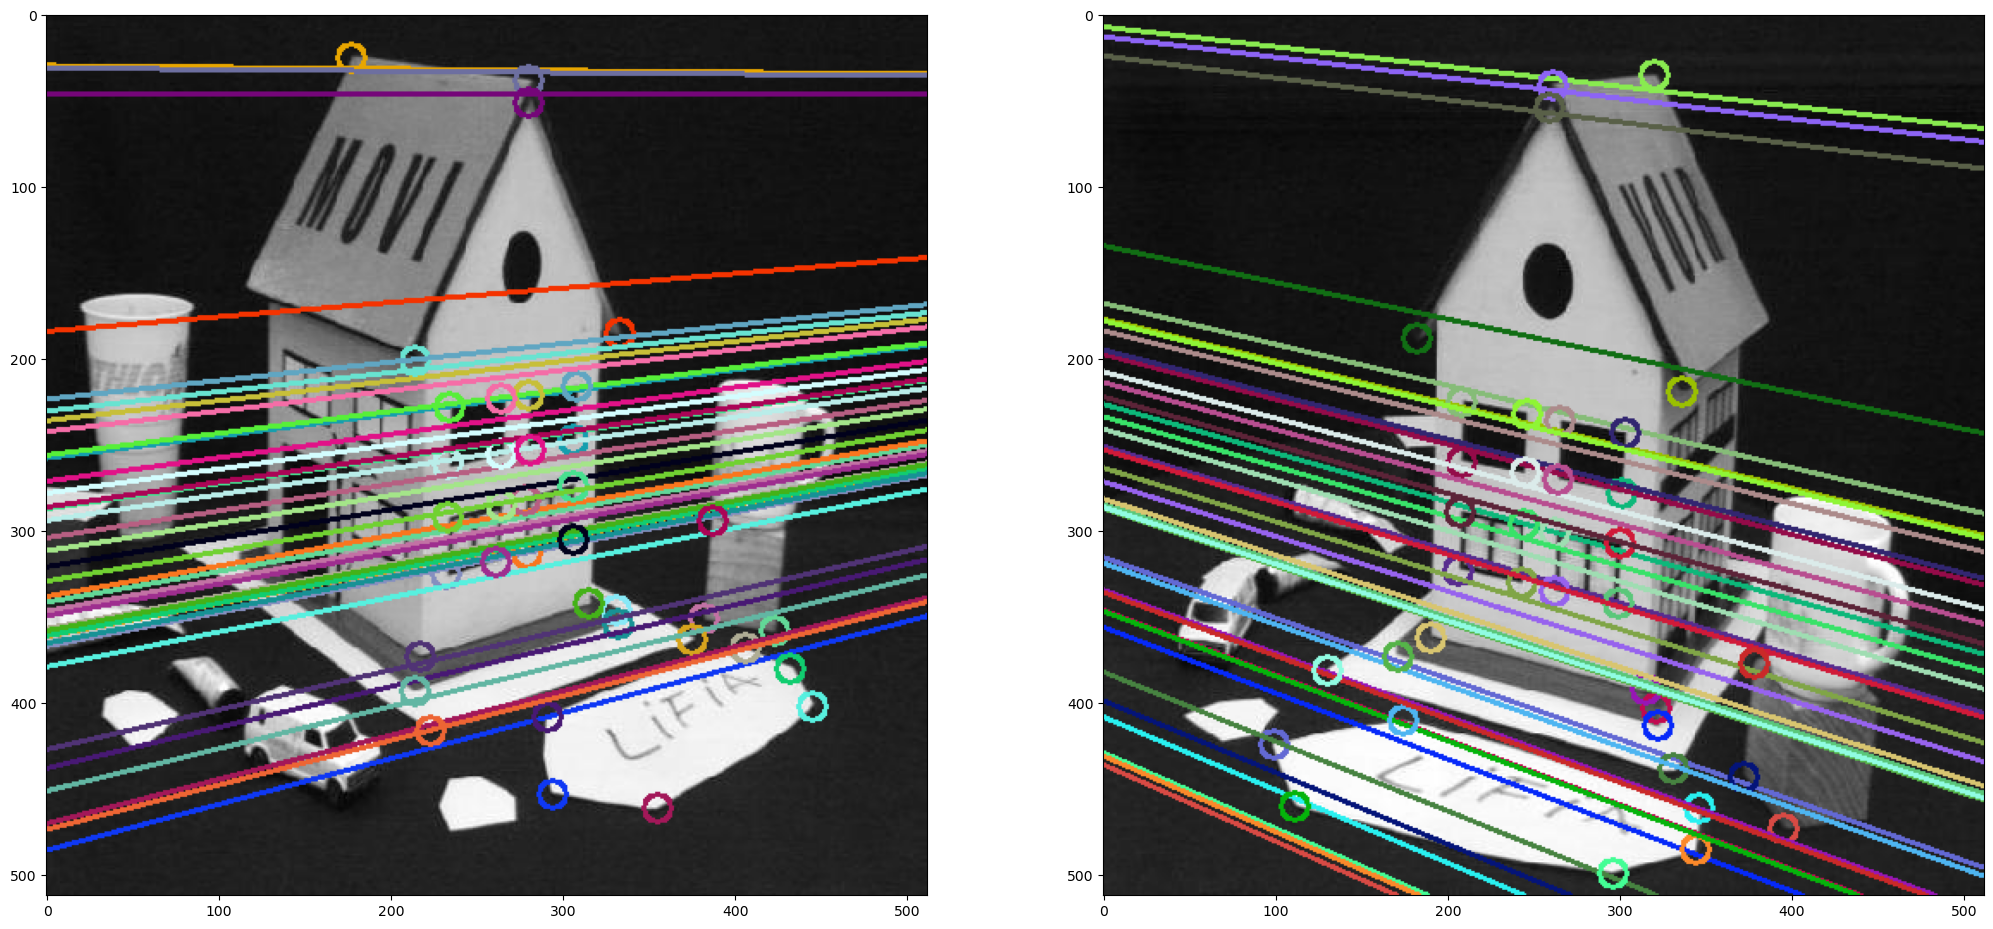

Using The fundamental Matrix with self implemented RANSAC applied


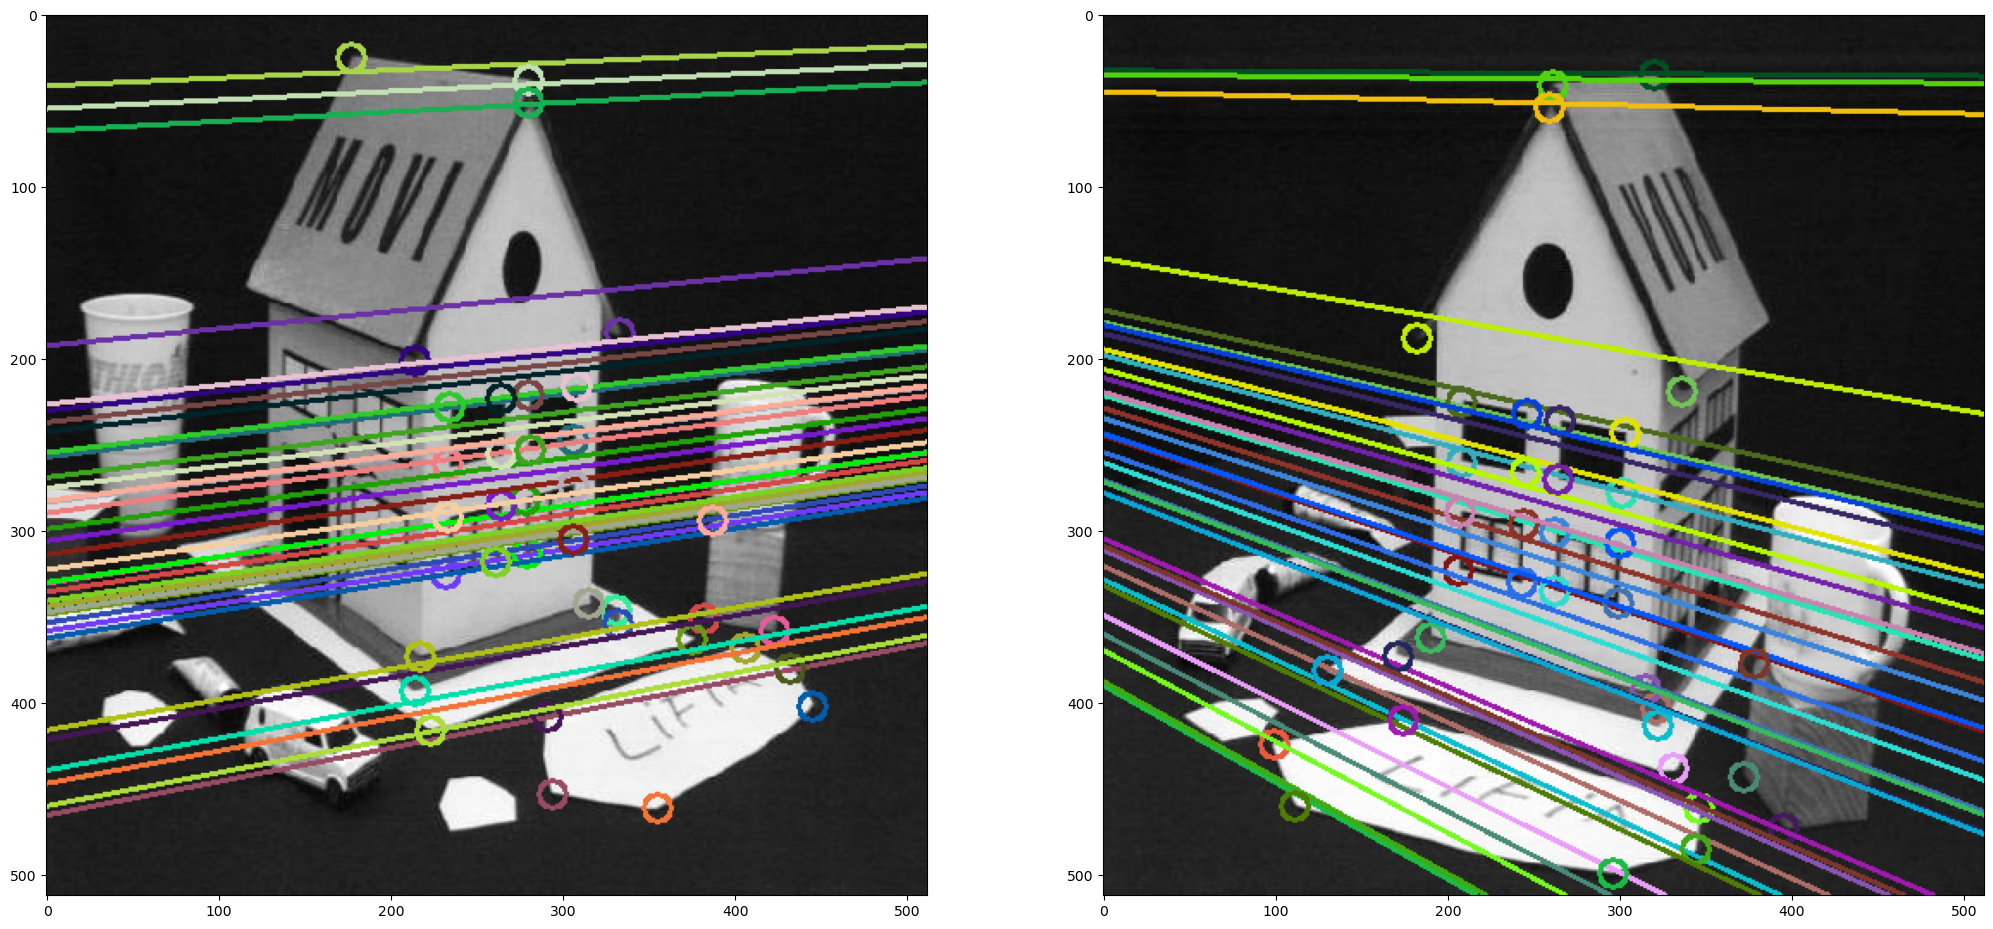

The fundamental Matrix using OPENCV built in function


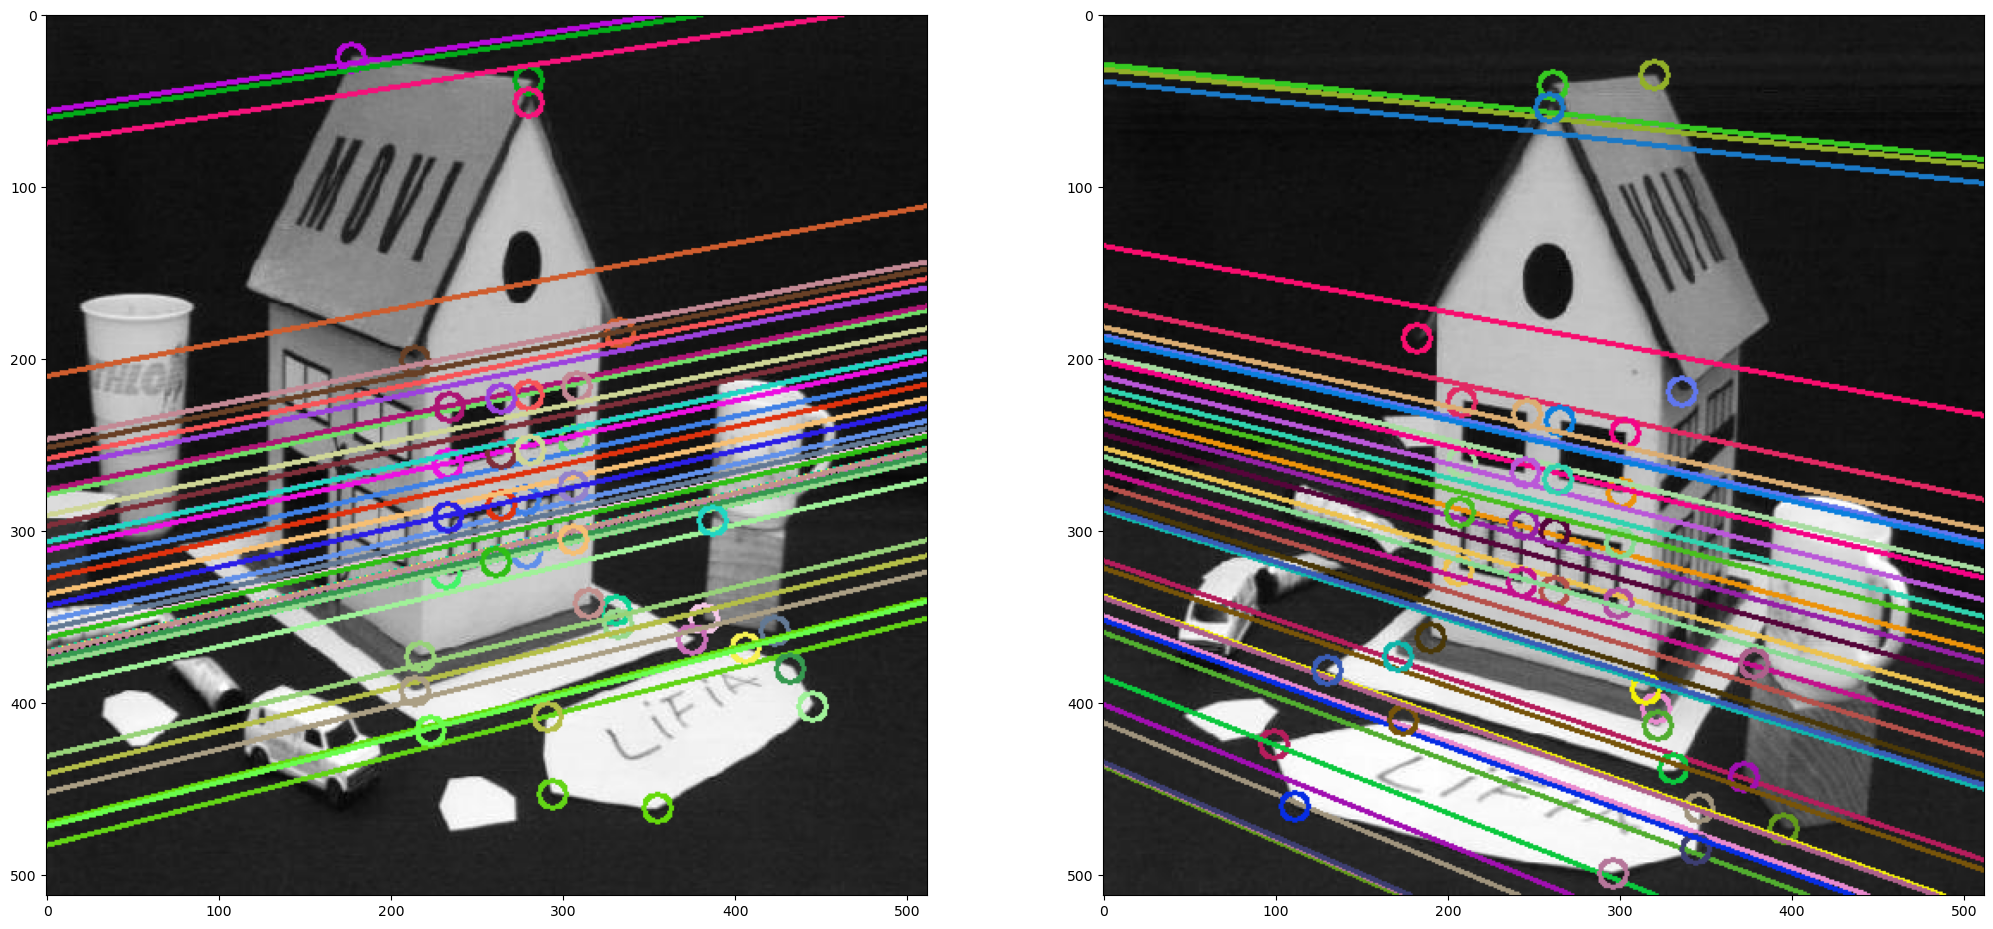

In [37]:
print("Using The fundamental Matrix, without RANSAC")
visualize_epilines(points_1, points_2, F)

print("Using The fundamental Matrix with self implemented RANSAC applied")
visualize_epilines(points_1, points_2, F_ransac)

print("The fundamental Matrix using OPENCV built in function")
visualize_epilines(points_1, points_2, F_ransac_2)


## Part 2

In [42]:
avg_distance = calculate_estimation_error(points_1, points_2, F)
print("Estimation error using the Fundamental matrix without RANSAC:", avg_distance)

avg_distance_RANSAC = calculate_estimation_error(points_1, points_2, F_ransac)
print("Estimation error using Using The fundamental Matrix with self implemented RANSAC applied:", avg_distance_RANSAC)

avg_distance_RANSAC_open_cv = calculate_estimation_error(points_1, points_2, F_ransac_2)
print("Estimation error using Using The fundamental Matrix using OPENCV built in function:", avg_distance_RANSAC_open_cv)

print(f'\n MSE of fundamental matrixes (With and without RANSAC) = {mean_squared_error(F,F_ransac) }')

print(f'\n MSE of fundamental matrixes (With and without RANSAC(built in)) = {mean_squared_error(F,F_ransac_2) }')

Estimation error using the Fundamental matrix without RANSAC: 0.8594996204690564
Estimation error using Using The fundamental Matrix with self implemented RANSAC applied: 4.416074608277226
Estimation error using Using The fundamental Matrix using OPENCV built in function: 2.463927678906736

 MSE of fundamental matrixes (With and without RANSAC) = 0.008804457487560067

 MSE of fundamental matrixes (With and without RANSAC(built in)) = 0.00014292217484311145


In [186]:
# Starting with the original pixel coordinates
noisy_pts = [points_1, points_2]

# Add noise with increasing standard deviation
for s in [0, 0.5, 1, 1.5, 2, 2.5]:
    print("\nGaussian noise: ", s)
    noisy_pts_1 = add_noise(noisy_pts[0], s)
    noisy_pts_2 = add_noise(noisy_pts[1], s)
    F_noisy = fundamental_matrix(noisy_pts_1, noisy_pts_2)
    F_noisy_ransac = fundamental_matrix_ransac_using_open_cv(noisy_pts_1, noisy_pts_2)
    np.random.seed(0)
    F_noisy_ransac_self = ransac_fundamental_matrix(noisy_pts_1, noisy_pts_2)


    avg_distance = calculate_estimation_error(points_1, points_2, F_noisy)
    print("Estimation error: ", avg_distance)

    avg_distance_ransac = calculate_estimation_error(noisy_pts_1, noisy_pts_2, F_noisy_ransac)
    print("Estimation error RANSAC built in:", avg_distance_ransac)

    avg_distance_ransac_self = calculate_estimation_error(noisy_pts_1, noisy_pts_2, F_noisy_ransac_self)
    print("Estimation error RANSAC self implemented:", avg_distance_ransac_self)

    print(f'\nMSE of fundamental matrixes (With and without RANSAC) = {mean_squared_error(F_noisy,F_noisy_ransac_self)}')
    print(f'MSE of fundamental matrixes (With and without RANSAC (built-in)) = {mean_squared_error(F_noisy,F_noisy_ransac)}')



Gaussian noise:  0
Estimation error:  0.8594996204690564
Estimation error RANSAC built in: 2.463927678906736
Estimation error RANSAC self implemented: 8.445988636502928

MSE of fundamental matrixes (With and without RANSAC) = 0.0014379583021857528
MSE of fundamental matrixes (With and without RANSAC (built-in)) = 0.00014292217484311145

Gaussian noise:  0.5
Estimation error:  0.9435267336923296
Estimation error RANSAC built in: 5.447642877591882
Estimation error RANSAC self implemented: 6.39372646972326

MSE of fundamental matrixes (With and without RANSAC) = 0.00025939057434110833
MSE of fundamental matrixes (With and without RANSAC (built-in)) = 8.175021477834536e-05

Gaussian noise:  1
Estimation error:  1.0527382075414118
Estimation error RANSAC built in: 4.023703482949018
Estimation error RANSAC self implemented: 35.00772968608803

MSE of fundamental matrixes (With and without RANSAC) = 0.08923739075601884
MSE of fundamental matrixes (With and without RANSAC (built-in)) = 0.00092

**Since for self implemented RANSAC, I had to set the random seed, I also used the built in function by OpenCV to observe and compare the change when we added gaussian noise to the points. Also. mean square error was calculated between the fundamental matrix with and without RANSAC**

## Observation 
Adding Gaussian noise to the keypoints used to find the fundamental matrix can significantly affect the estimation error of the fundamental matrix. The effect of noise on the estimation error depends on various factors, including the amount of noise, the quality of the keypoints, etc

- Without RANSAC implementation, the estimation error of the fundamental matrix can be severely affected by the noise. The noise can cause incorrect correspondences to be detected between the two images, resulting in a fundamental matrix that does not accurately represent the geometric relationship between the two views. As a result, the estimated fundamental matrix may not be able to provide accurate results for tasks such as stereo reconstruction, structure from motion, or object tracking.

- RANSAC (Random Sample Consensus) is a robust estimation method that can help mitigate the effect of noise on the estimation of the fundamental matrix. RANSAC can handle noisy data by iteratively selecting a subset of correspondences and fitting a model (in this case, the fundamental matrix) to the subset. The subset with the best fit is then used to estimate the fundamental matrix. RANSAC is particularly effective when the amount of noise is small, and when the majority of correspondences are inliers (i.e., correspondences that are consistent with the geometric relationship between the two views). This can be obsereved in the results above that when the noise is increased,the results of RANSAC start deteriorating.

In summary, adding Gaussian noise to keypoints can significantly affect the estimation error of the fundamental matrix. Without RANSAC implementation, the estimation error can be severe due to incorrect correspondences. However, RANSAC can help mitigate the effect of noise on the estimation of the fundamental matrix by selecting the subset of correspondences that best fit the model.

**:NOTE:** Please note that the distance is calculated not with the noisy points, rather with the original points

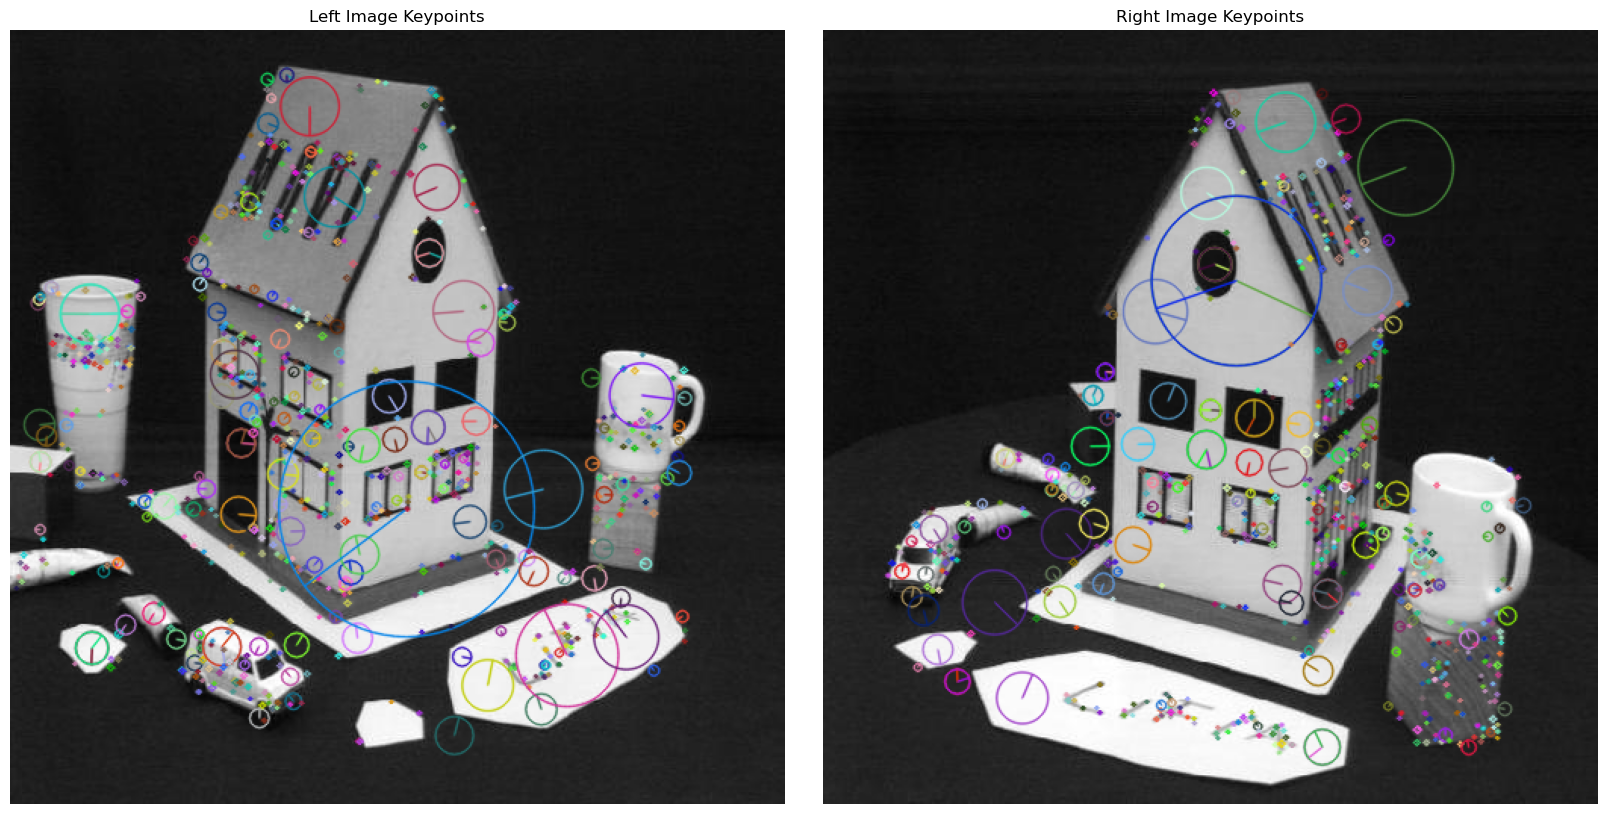

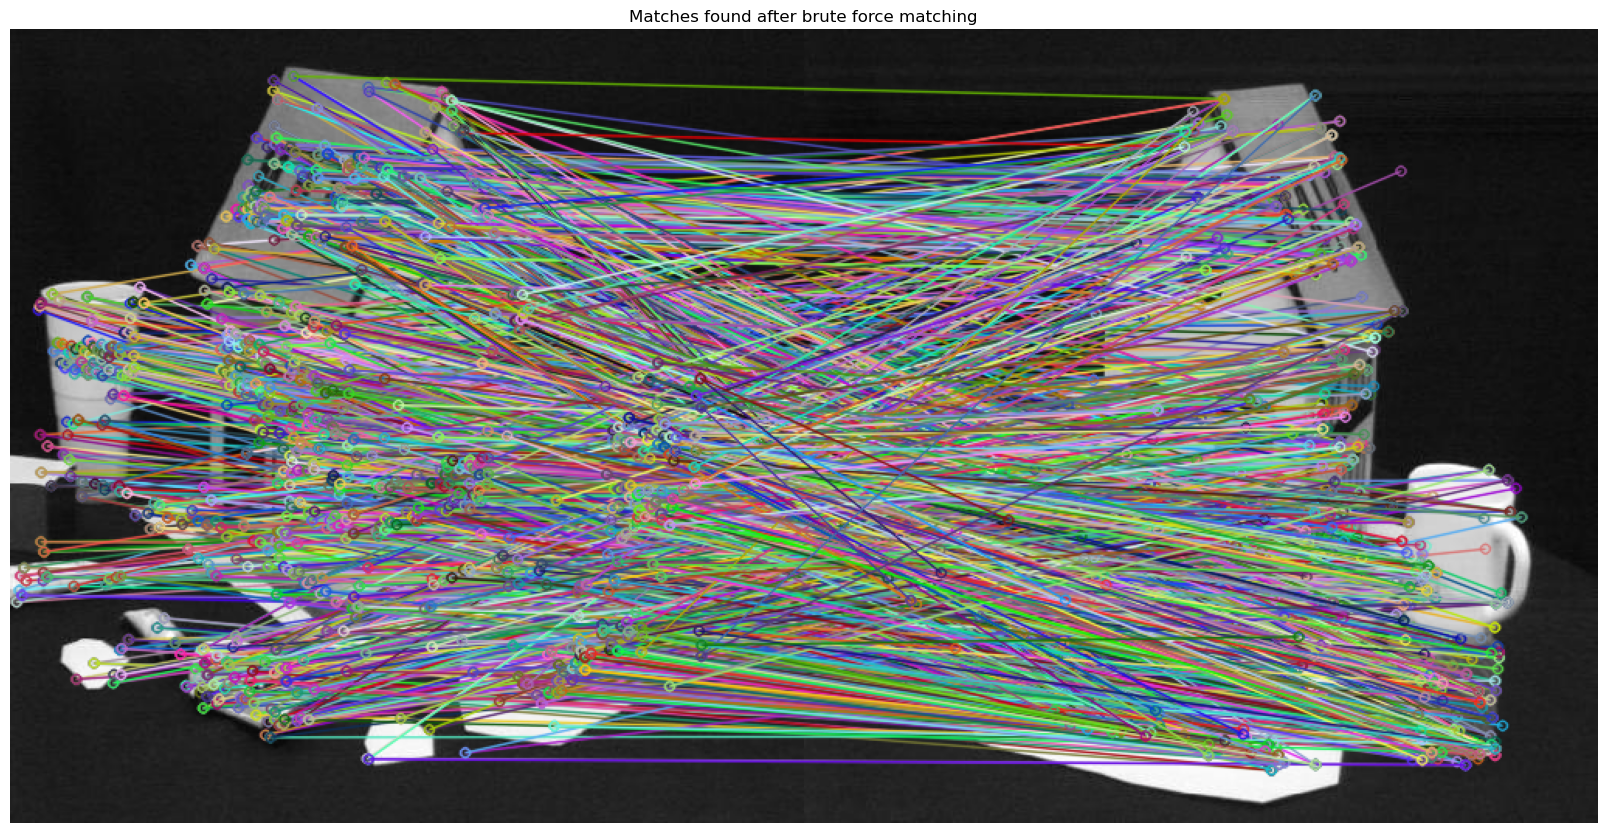

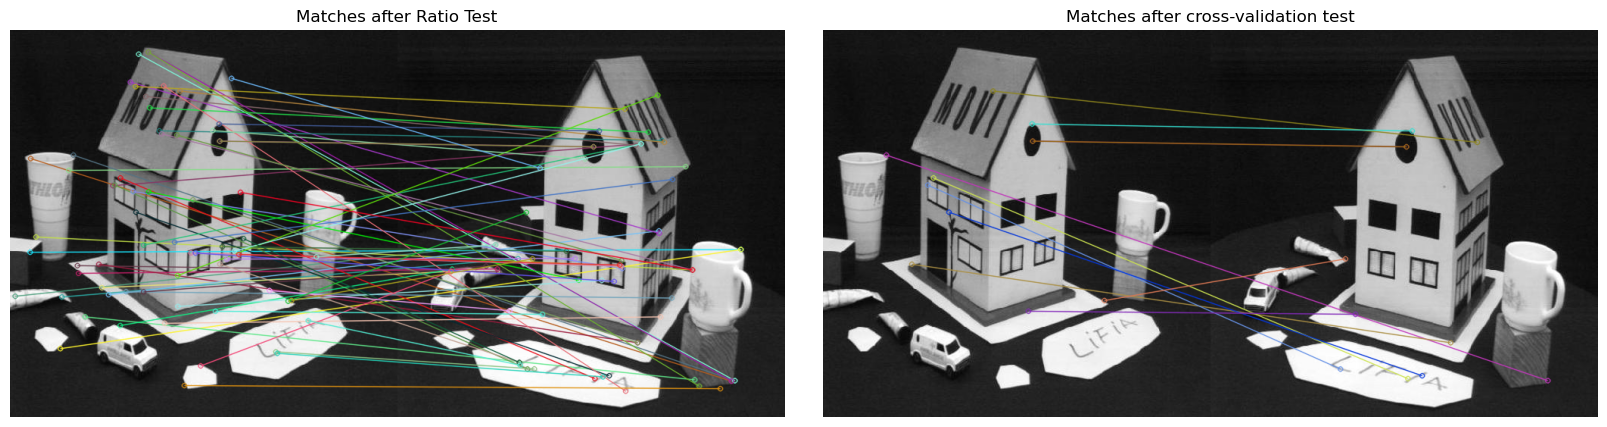

In [157]:
# Detect and extract SIFT features from the images
keypoints1, descriptors1 = detect_and_extract_sift(image_1)
keypoints2, descriptors2 = detect_and_extract_sift(image_2)

keypoint_image_1 = drawKeypoints(image_1, keypoints1)
keypoint_image_2 = drawKeypoints(image_2, keypoints2)

plt.figure(figsize=(image_2.shape[1]/25, image_2.shape[0]/25))
plt.subplot(121), plt.imshow(keypoint_image_1), plt.title('Left Image Keypoints'), plt.axis('off')
plt.subplot(122), plt.imshow(keypoint_image_2), plt.title('Right Image Keypoints'), plt.axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()


# Match SIFT descriptors between the images
matches = match_sift_descriptors(descriptors1, descriptors2)

matched_image = cv2.drawMatchesKnn(image_1, keypoints1, image_2, keypoints2,
                                       matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(image_2.shape[1]/25, image_2.shape[0]/25))
plt.imshow(matched_image)
plt.axis('off')
plt.title('Matches found after brute force matching')
plt.show()





good_matches, inlier_matches = remove_sift_outliers(keypoints1, keypoints2, matches)


# Draw keypoints and matches before and after outlier removal
img_before = cv2.drawMatches(image_1, keypoints1, image_2, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
img_after = cv2.drawMatches(image_1, keypoints1, image_2, keypoints2, inlier_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

fig, axs = plt.subplots(1, 2, figsize=(image_2.shape[1]/25, image_2.shape[0]/25))
axs[0].imshow(cv2.cvtColor(img_before, cv2.COLOR_BGR2RGB))
axs[0].set_title('Matches after Ratio Test')
axs[0].axis('off')
axs[1].imshow(cv2.cvtColor(img_after, cv2.COLOR_BGR2RGB))
axs[1].set_title('Matches after cross-validation test')
axs[1].axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()





In [159]:
# Convert keypoints to numpy arrays of coordinates
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in inlier_matches ]).reshape(-1,2)
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in inlier_matches ]).reshape(-1,2)
# Reshape arrays to match required format
points_1_SIFT_inliers = np.int32(src_pts)
points_2_SIFT_inliers = np.int32(dst_pts)

SIFT_F = fundamental_matrix(points_1_SIFT_inliers, points_2_SIFT_inliers)
print("The fundamental Matrix using the keypoints in the inlier matches is: \n", SIFT_F)

SIFT_F_self_RANSAC = ransac_fundamental_matrix(points_1_SIFT_inliers, points_2_SIFT_inliers)
print("\nThe fundamental Matrix (bself RANSAC) using the keypoints in the inlier matches is: \n", SIFT_F_self_RANSAC)

SIFT_F_built_in_RANSAC, _ = cv2.findFundamentalMat(points_1_SIFT_inliers, points_2_SIFT_inliers, cv2.FM_RANSAC, 0.01, 0.99)
print("\nThe fundamental Matrix (built in function RANSAC) using the keypoints in the inlier matches is: \n", SIFT_F_built_in_RANSAC)

SIFT_F_built_in_8point, _ = cv2.findFundamentalMat(points_1_SIFT_inliers, points_2_SIFT_inliers, cv2.FM_8POINT)
print("\nThe fundamental Matrix (built in function) using the keypoints in the inlier matches is: \n", SIFT_F_built_in_8point)


The fundamental Matrix using the keypoints in the inlier matches is: 
 [[-1.06444202e-05  6.46649602e-06  1.05932290e-04]
 [ 9.51731755e-06  1.78823559e-06 -2.36188912e-03]
 [-5.78081078e-04 -2.96857199e-03  1.00000000e+00]]

The fundamental Matrix (bself RANSAC) using the keypoints in the inlier matches is: 
 [[ 1.26461388e-05 -5.54730995e-06 -3.77655404e-03]
 [ 1.49334440e-06 -1.41443092e-06 -2.69714539e-04]
 [-3.26755549e-03  1.32906710e-03  1.00000000e+00]]

The fundamental Matrix (built in function RANSAC) using the keypoints in the inlier matches is: 
 [[ 1.25096215e-05  3.30686884e-06 -1.95637460e-03]
 [ 8.63787343e-06 -1.52588844e-05 -6.77436067e-04]
 [-8.45232729e-03  6.14964049e-03  1.00000000e+00]]

The fundamental Matrix (built in function) using the keypoints in the inlier matches is: 
 [[-1.06366967e-05  6.46675568e-06  1.04786297e-04]
 [ 9.50662375e-06  1.79704707e-06 -2.36173080e-03]
 [-5.76301747e-04 -2.97126951e-03  1.00000000e+00]]


In [167]:
SIFT_avg_distance = calculate_estimation_error(points_1_SIFT_inliers, points_2_SIFT_inliers, SIFT_F)
print("Estimation error using the Fundamental matrix without RANSAC:\n", SIFT_avg_distance)

SIFT_avg_distance_RANSAC = calculate_estimation_error(points_1_SIFT_inliers, points_2_SIFT_inliers, SIFT_F_self_RANSAC)
print("Estimation error using The fundamental Matrix with self implemented RANSAC applied:\n", SIFT_avg_distance_RANSAC)

SIFT_avg_distance_RANSAC_open_cv = calculate_estimation_error(points_1_SIFT_inliers, points_2_SIFT_inliers, SIFT_F_built_in_RANSAC)
print("Estimation error using The fundamental Matrix using OPENCV RANSAC built in function:\n", SIFT_avg_distance_RANSAC_open_cv)

SIFT_avg_distance_8point_open_cv = calculate_estimation_error(points_1_SIFT_inliers, points_2_SIFT_inliers, SIFT_F_built_in_8point)
print("Estimation error using The fundamental Matrix using OPENCV 8POINT built in function:\n", SIFT_avg_distance_8point_open_cv)

print(f'\nMSE of fundamental matrixes (With and without RANSAC) = {mean_squared_error(SIFT_F,SIFT_F_self_RANSAC) }')
print(f'MSE of fundamental matrixes (With and without RANSAC(built in)) = {mean_squared_error(SIFT_F,SIFT_F_built_in_RANSAC) }')
print(f'MSE of fundamental matrixes (F_SIFT vs opencv F)) = {mean_squared_error(SIFT_F,SIFT_F_built_in_8point) }')

Estimation error using the Fundamental matrix without RANSAC:
 0.4607161383398555
Estimation error using The fundamental Matrix with self implemented RANSAC applied:
 81.00727210024542
Estimation error using The fundamental Matrix using OPENCV RANSAC built in function:
 17.67207696839151
Estimation error using The fundamental Matrix using OPENCV 8POINT built in function:
 0.5154199816963889

MSE of fundamental matrixes (With and without RANSAC) = 5.0171811519996614e-06
MSE of fundamental matrixes (With and without RANSAC(built in)) = 1.6915209064928374e-05
MSE of fundamental matrixes (F_SIFT vs opencv F)) = 1.309025903155377e-12


In [187]:
# Starting with the original pixel coordinates
noisy_pts_SIFT = [points_1_SIFT_inliers, points_2_SIFT_inliers]

# Add noise with increasing standard deviation
for s in [0, 0.5, 1, 1.5, 2, 2.5]:
    print("\nGaussian noise: ", s)
    noisy_pts_SIFT_1 = add_noise(noisy_pts_SIFT[0], s)
    noisy_pts_SIFT_2 = add_noise(noisy_pts_SIFT[1], s)

    F_noisy_SIFT = fundamental_matrix(noisy_pts_SIFT_1, noisy_pts_SIFT[1])
    np.random.seed(0)
    F_noisy_ransac_self_SIFT = ransac_fundamental_matrix(noisy_pts_SIFT_1, noisy_pts_SIFT_2)
    F_noisy_8POINT_builtin_SIFT, _ = cv2.findFundamentalMat(noisy_pts_SIFT_1, noisy_pts_SIFT_2, cv2.FM_8POINT)


    SIFT_avg_distance = calculate_estimation_error(noisy_pts_SIFT_1, noisy_pts_SIFT_2, F_noisy_SIFT)
    print("Estimation error: ", SIFT_avg_distance)


    avg_distance_ransac_self = calculate_estimation_error(noisy_pts_SIFT_1, noisy_pts_SIFT_2, F_noisy_ransac_self_SIFT)
    print("Estimation error RANSAC self implemented:", avg_distance_ransac_self)

    avg_distance_8point_builtin = calculate_estimation_error(noisy_pts_SIFT_1, noisy_pts_SIFT_2, F_noisy_8POINT_builtin_SIFT)
    print("Estimation error built in 8 point implemented:", avg_distance_8point_builtin)


    print(f'\nMSE of fundamental matrixes (With and without RANSAC) = {mean_squared_error(F_noisy_SIFT,F_noisy_ransac_self_SIFT)}')
    print(f'MSE of fundamental matrixes (F_SIFT vs opencv F)) = {mean_squared_error(F_noisy_SIFT,F_noisy_8POINT_builtin_SIFT) }')


Gaussian noise:  0
Estimation error:  0.4607235491275784
Estimation error RANSAC self implemented: 58.8313395819534
Estimation error built in 8 point implemented: 0.5154203181373004

MSE of fundamental matrixes (With and without RANSAC) = 1.8232733279611608e-06
MSE of fundamental matrixes (F_SIFT vs opencv F)) = 1.309025903155377e-12

Gaussian noise:  0.5
Estimation error:  0.5926442933100775
Estimation error RANSAC self implemented: 116.3636766528721
Estimation error built in 8 point implemented: 0.38358249169943115

MSE of fundamental matrixes (With and without RANSAC) = 2.260968637438611e-05
MSE of fundamental matrixes (F_SIFT vs opencv F)) = 4.832109833654545e-09

Gaussian noise:  1
Estimation error:  1.3523894608912783
Estimation error RANSAC self implemented: 97.04763543497211
Estimation error built in 8 point implemented: 1.3363876723590729

MSE of fundamental matrixes (With and without RANSAC) = 1.1455859885323694e-05
MSE of fundamental matrixes (F_SIFT vs opencv F)) = 2.00793